In [95]:
from dataclasses import dataclass
import pandas as pd
import os
import SimpleITK as sitk

import keras as tfk
from keras import layers as tfkl

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

sns.set_theme()

In [96]:
SEED = 42
BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512
SHUFFLE_BUFFER_SIZE = 100
METRICS = ["accuracy", "recall", "f1_score"]

data_dir = '/kaggle/input/lung-ds-norm/Full_slice'

tfk.utils.set_random_seed(SEED)

In [97]:
train_datagen = ImageDataGenerator(
    rotation_range=30,            
    width_shift_range=0.2,        
    height_shift_range=0.2,       
    shear_range=0.2,              
    zoom_range=0.2,               
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0    
)

val_datagen = ImageDataGenerator(

)

train_generator = train_datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    #subset='training'               
)

val_generator = val_datagen.flow_from_directory(
    data_dir + "/val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    #subset='val'
)

Found 1885 images belonging to 5 classes.
Found 475 images belonging to 5 classes.


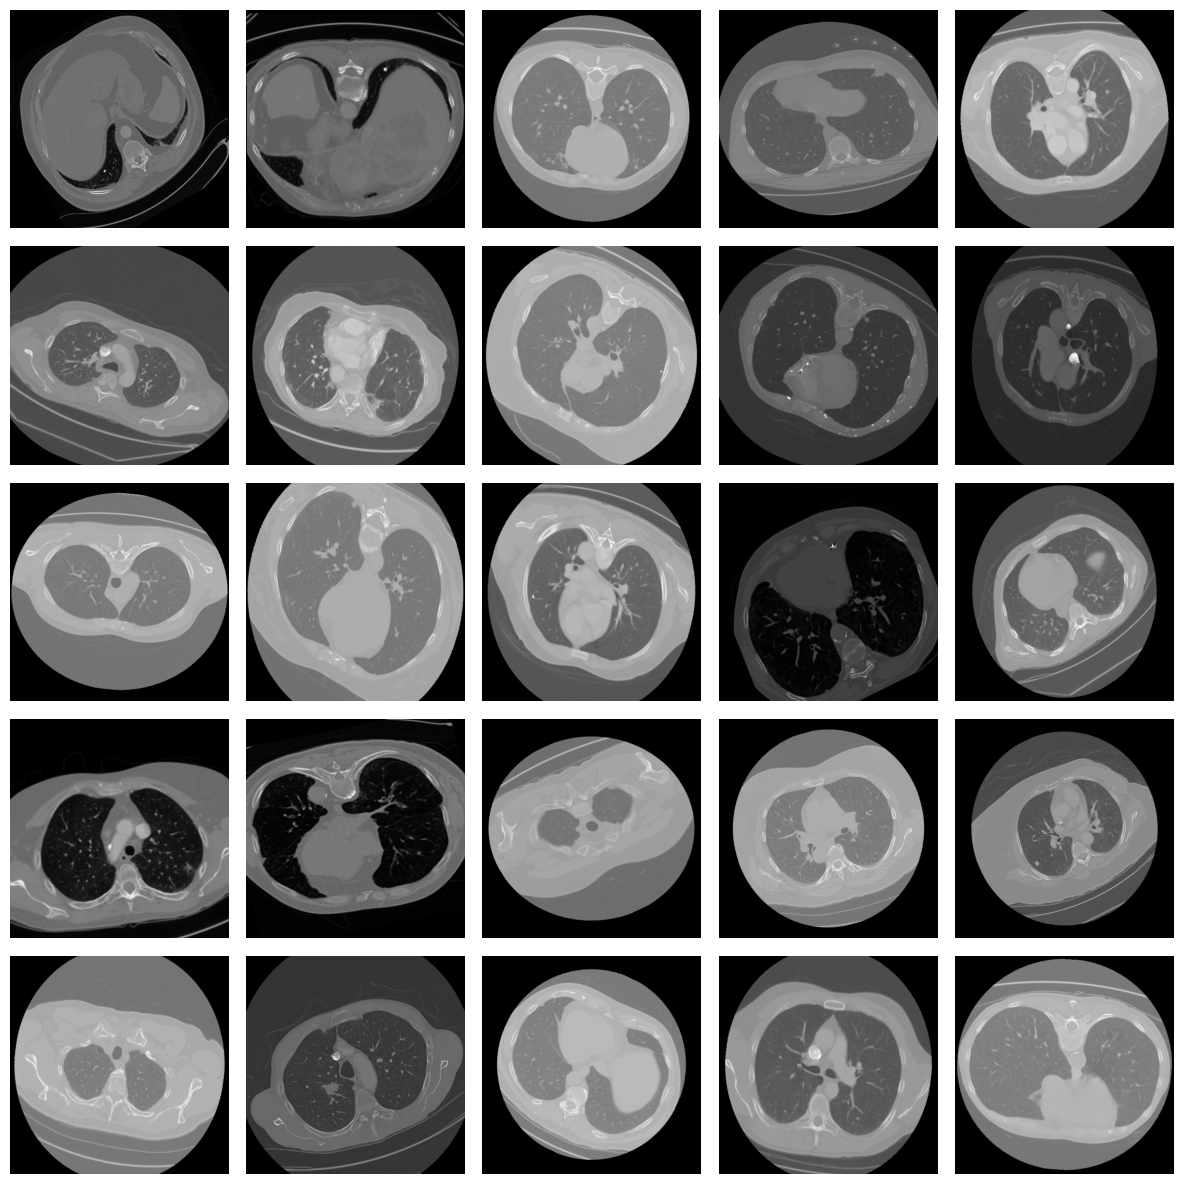

In [98]:
# Get one batch of augmented images
augmented_images, _ = next(train_generator)  # Ignore labels (_)

# Plot a 5x5 grid of augmented images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.flatten()

for img, ax in zip(augmented_images[:25], axes):  # Take the first 25 images
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [99]:
@dataclass
class Hyperparameters:
    # Model
    activation = "relu"
    # Training
    noise_std: float = 0.05 # then try 0.1
    optimiser = tfk.optimizers.Adam
    learning_rate = 1e-4
    weight_decay = 1e-4
    regularization1 = tfk.regularizers.L1L2(l1=1e-5, l2=0)
    regularization2 = tfk.regularizers.L1L2(l1=0, l2=0)
    loss = tfk.losses.CategoricalCrossentropy()
    epochs = 50
    ## Early stopping parameters
    es_patience = 10
    es_min_delta = 1e-2
    ## Learning rate schedule
    lr_patience = 5
    lr_decay_factor = 0.3
    lr_min_delta = 5e-2 
    min_lr = 1e-6

hp = Hyperparameters()

In [100]:
def build_model(hp: Hyperparameters,
                feature_extractor: tfk.applications):
    
    inputs = tfkl.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    x = tfkl.Rescaling(1./255)(inputs)
    gn = tfkl.GaussianNoise(hp.noise_std)(x)
    x = tfkl.Rescaling(255)(gn)

    backbone_output = feature_extractor(x)

    conv_layer = tfkl.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(backbone_output) 
    max_pool_layer = tfkl.MaxPooling2D(pool_size=(2, 2))(conv_layer)
    flatten_layer = tfkl.Flatten()(max_pool_layer) 

    x = tfkl.Dropout(0.6)(flatten_layer)

    x = tfkl.Dense(1024, activation='relu')(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.Dense(256, activation='relu')(x)
    #x = tfkl.Dense(128, activation='relu')(x)

    x = tfkl.Dropout(0.4)(x)

    output = tfkl.Dense(5, activation="softmax")(x)
    
    model = tfk.Model(inputs, output)
    return model

In [101]:
def fit(model: tfk.Model,
        train_generator: ImageDataGenerator,
        val_generator: ImageDataGenerator,
        hp: Hyperparameters):
    model.compile(loss=hp.loss,
                  optimizer=hp.optimiser(learning_rate=hp.learning_rate, weight_decay=hp.weight_decay), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=hp.epochs,
        #validation_data=val_dataset,
        callbacks=[
            tfk.callbacks.EarlyStopping(monitor='val_loss', 
                                        #mode='min',
                                        patience=hp.es_patience, 
                                        restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(
                factor=hp.lr_decay_factor,
                patience=hp.lr_patience,
                min_delta=hp.lr_min_delta,
                min_lr=hp.min_lr,
                verbose=1,
            )
    ]
    
    ).history

    return model, history

In [102]:
backbone = tfk.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(512,512,3),
    pooling=None #'avg'
)

backbone.trainable = False

model = build_model(hp, backbone)

model, history = fit(model, train_generator, val_generator, hp)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.2187 - loss: 2.2770 - val_accuracy: 0.2611 - val_loss: 1.5946 - learning_rate: 1.0000e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.2307 - loss: 1.6210 - val_accuracy: 0.2968 - val_loss: 1.5556 - learning_rate: 1.0000e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.2802 - loss: 1.5838 - val_accuracy: 0.2821 - val_loss: 1.5526 - learning_rate: 1.0000e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.2734 - loss: 1.5696 - val_accuracy: 0.3158 - val_loss: 1.5317 - learning_rate: 1.0000e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3109 - loss: 1.5606 - val_accuracy: 0.3411 - val_loss: 1.5163 - learning_rate: 1.0000e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.3170 - loss: 1.5274 - val_accuracy: 0.3558 - val_loss: 1.4864 - learning_rate: 1.0000e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3404 

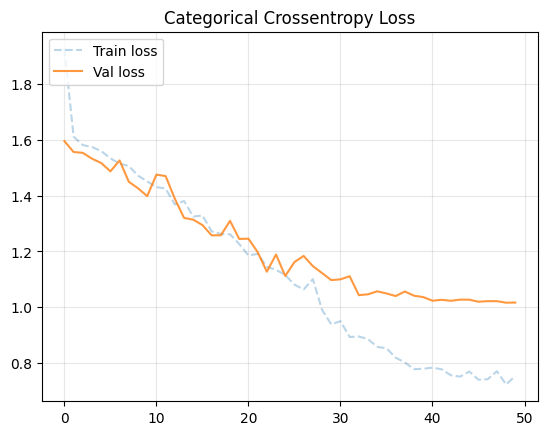

In [103]:
# Plot loss curves
plt.style.use('default')
plt.plot(history['loss'], label='Train loss', alpha=0.3, linestyle='--')
plt.plot(history['val_loss'], label='Val loss', alpha=0.8)
plt.title('Categorical Crossentropy Loss')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

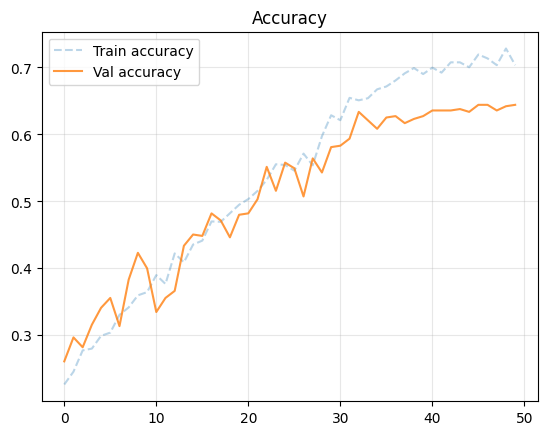

In [106]:
# Plot accuracy curves
plt.style.use('default')
plt.plot(history['accuracy'], label='Train accuracy', alpha=0.3, linestyle='--')
plt.plot(history['val_accuracy'], label='Val accuracy', alpha=0.8)
plt.title('Accuracy')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 708ms/step
Accuracy:  0.6421052631578947


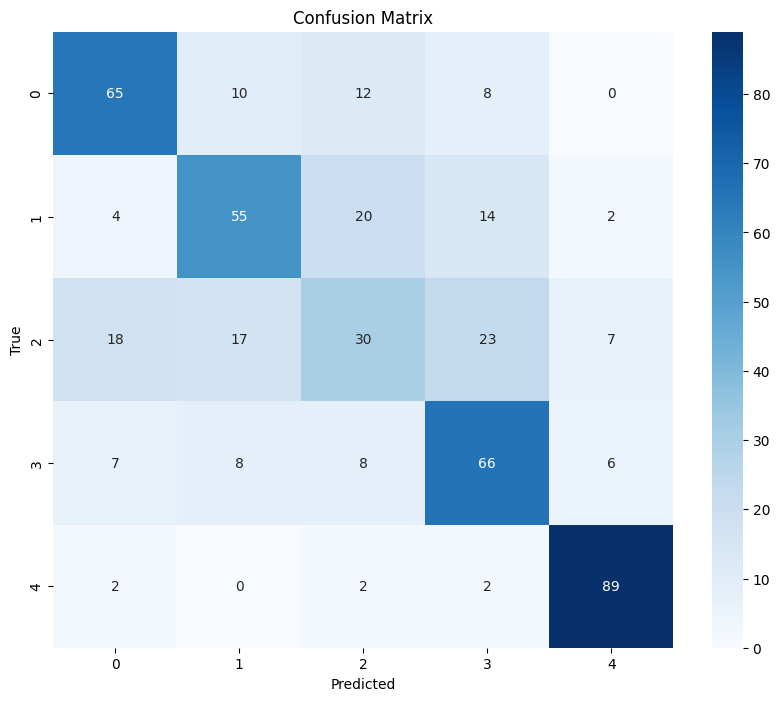

In [104]:
# Predict on validation data and plot confusion matrix
y_true = []
for _, labels in val_generator:
    y_true.extend(labels)
    if len(y_true) >= val_generator.samples:  # Stop when all samples are processed
        break
y_true = np.array(y_true)

if val_generator.class_mode == 'categorical':
    y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class indices

y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
print("Accuracy: ", accuracy_score(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()